In [ ]:
# default_exp funcs.file_io

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# File handling

In [ ]:
#export
from decode_fish.imports import *
from decode_fish.funcs.utils import *
from tifffile import imread
from decode_fish.engine.microscope import Microscope
from decode_fish.engine.psf import crop_psf
from decode_fish.engine.psf import LinearInterpolatedPSF
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.dataset import *
from torch.utils.data import DataLoader

In [ ]:
#export
def load_model_state(model, path):
    """
    Loads the network parameters, the intensity parameters and the scaling into model given a path.
    """
    model_dict = torch.load(path)
    model.load_state_dict(model_dict['state_dict'])
    model.inp_scale = model_dict['scaling'][0]
    model.inp_offset = model_dict['scaling'][1]
    return model

In [ ]:
#export
def simfish_to_df(sim_file, frame_idx=0, int_fac=1.05):
    
    yxzi = []
    with open(sim_file) as f:
        read = False
        for line in f:
            if 'Pos_Y' in line: 
                read = True
                continue
            if 'SPOTS_END' in line: break
            if read: yxzi.append([float(s) for s in line.split()])

    yxzi = np.array(yxzi)#/px_size
    loc_idx = np.arange(len(yxzi))
    # Number calculated by taking into account their (or my?) normalization (by max and not by sum)
    if yxzi.shape[1] == 4:
        # PSF.max() | PSF.sum() | 3**3 (superres)  | PSF.max() | microscope scale
        # ints = yxzi[:,3] * 65535.0 * 156772560.0 / 27 / 65535.0 / 10000.0
        ints = yxzi[:,3] * 65535.0 / 100.0 / int_fac
    else:
        ints = np.ones_like(loc_idx)
    
    df = pd.DataFrame({'loc_idx': loc_idx,
                       'frame_idx': frame_idx,
                       'x': yxzi[:,1],
                       'y': yxzi[:,0], 
                       'z': yxzi[:,2], 
                       'prob': np.ones_like(loc_idx), 
                       'int': ints, 
                       'int_sig': np.ones_like(loc_idx), 
                       'x_sig': np.ones_like(loc_idx), 
                       'y_sig': np.ones_like(loc_idx), 
                       'z_sig': np.ones_like(loc_idx)})

    return df   


def matlab_fq_to_df(resfile, frame_idx=0):
    
    ind_dict = {'x':1, 'y':0, 'z':2, 'int':3, 'x_sig':6, 'y_sig':7, 'z_sig':8}
    
    yxzi = []
    with open(resfile) as f:
        read = False
        for line in f:
            if 'Pos_Y' in line: 
                read = True
                continue
            if 'SPOTS_END' in line: break
            if read: yxzi.append([float(s) for s in line.split()])

    yxzi = np.array(yxzi)#/px_size
    loc_idx = np.arange(len(yxzi))
    
    df = pd.DataFrame({'loc_idx': loc_idx,
                       'frame_idx': frame_idx,
                       'x': yxzi[:,ind_dict['x']],
                       'y': yxzi[:,ind_dict['y']], 
                       'z': yxzi[:,ind_dict['z']], 
                       'prob': np.ones_like(loc_idx), 
                       'int': yxzi[:,ind_dict['int']], 
                       'int_sig': np.ones_like(loc_idx), 
                       'x_sig': yxzi[:,ind_dict['x_sig']], 
                       'y_sig': yxzi[:,ind_dict['y_sig']], 
                       'z_sig': yxzi[:,ind_dict['z_sig']],
                       'comb_sig' : np.sqrt(yxzi[:,ind_dict['x_sig']]**2
                                              +yxzi[:,ind_dict['y_sig']]**2
                                              +yxzi[:,ind_dict['z_sig']]**2)})

    return df 

#export 
def load_sim_fish(basedir, mrna_lvl=200, shape='cell3D', exp_strength='strong', cell_nr=0, shift=[-38,-38,-110], int_fac=1.05):
    
    spec_dir = f'/mRNAlevel_{mrna_lvl}/{shape}/{exp_strength}/'
    img_path = sorted(glob.glob(basedir + spec_dir + 'w1*.tif'))[cell_nr]
    cellname = Path(img_path).name.split('.')[0]
#     print(name)
    img = load_tiff_image(img_path)
    gt_df = simfish_to_df(img_path.split('.')[0] + '.txt', int_fac=int_fac)
    fq_nog_df = fq_gmm_df = DF()
    if os.path.exists(basedir + '/_results_detection/'):
        nog_path = Path(basedir + '/_results_detection/' + spec_dir + '/results_noGMM/' + cellname + '_res_NO_GMM.txt')
        gmm_path = Path(basedir + '/_results_detection/' + spec_dir + '/results_GMM/' + cellname + '_res_GMM.txt')

        if nog_path.is_file(): 
            fq_nog_df = simfish_to_df(nog_path, int_fac=int_fac)
            fq_nog_df = shift_df(fq_nog_df, shift)
        if gmm_path.is_file(): 
            fq_gmm_df = simfish_to_df(gmm_path, int_fac=int_fac)
            fq_gmm_df = shift_df(fq_gmm_df, shift)
        
    return img, gt_df, fq_nog_df, fq_gmm_df

#export
def big_fishq_to_df(file_str):
    
    csv = pd.read_csv(file_str,sep=';',names=['z','y','x'], index_col=False)

    zyx = np.array(csv)
    loc_idx = np.arange(len(zyx))

    df = pd.DataFrame({'loc_idx': loc_idx,
                       'frame_idx': np.zeros_like(loc_idx),
                       'x': zyx[:,2],
                       'y': zyx[:,1], 
                       'z': zyx[:,0], 
                       'prob': np.ones_like(loc_idx), 
                       'int': np.ones_like(loc_idx), 
                       'int_sig': np.ones_like(loc_idx), 
                       'x_sig': np.ones_like(loc_idx), 
                       'y_sig': np.ones_like(loc_idx), 
                       'z_sig': np.ones_like(loc_idx)})
    
    return df

def rsfish_to_df(file_str):
    
    csv = pd.read_csv(file_str,sep='  ',names=['x','y','z','?','??'], index_col=False)
    
    xyz = np.array(csv)
    loc_idx = np.arange(len(xyz))

    df = pd.DataFrame({'loc_idx': loc_idx,
                       'frame_idx': np.zeros_like(loc_idx),
                       'x': xyz[:,1],
                       'y': xyz[:,0], 
                       'z': xyz[:,2], 
                       'prob': np.ones_like(loc_idx), 
                       'int': np.ones_like(loc_idx), 
                       'int_sig': np.ones_like(loc_idx), 
                       'x_sig': np.ones_like(loc_idx), 
                       'y_sig': np.ones_like(loc_idx), 
                       'z_sig': np.ones_like(loc_idx)})
    
    return df

In [ ]:
basedir = '/groups/turaga/home/speisera/share_TUM/FishSIM/sim_density_fac1_2/'
img, gt_df, fq_nog_df, fq_gmm_df = load_sim_fish(basedir, 250, 'random', 'NR', 2)

(array([29., 51., 69., 62., 41., 18.,  9., 11.,  0.,  1.]),
 array([ 2.76709367,  3.5775725 ,  4.38805134,  5.19853017,  6.00900901,
         6.81948784,  7.62996668,  8.44044551,  9.25092434, 10.06140318,
        10.87188201]),
 <BarContainer object of 10 artists>)

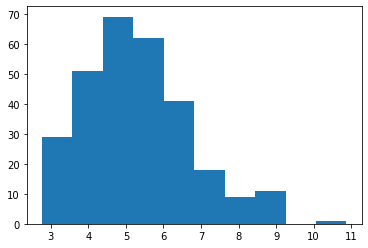

In [ ]:
plt.hist(gt_df['int'])

In [ ]:
# load_big_fishq('deepstorm/datasets/CodFish/smFISH_data_Titlow/detections/sgg_smFISH_4_spots.csv')
f_name = '../../../deepstorm/datasets/CodFish/smFISH_data_Titlow/detections/sgg_smFISH_4_spots.csv'
tiff = load_tiff_image(Path(f_name).parent.parent/'sgg_smFISH_4.tif')
print(tiff.shape)

df = big_fishq_to_df(f_name)

torch.Size([1, 25, 512, 512])


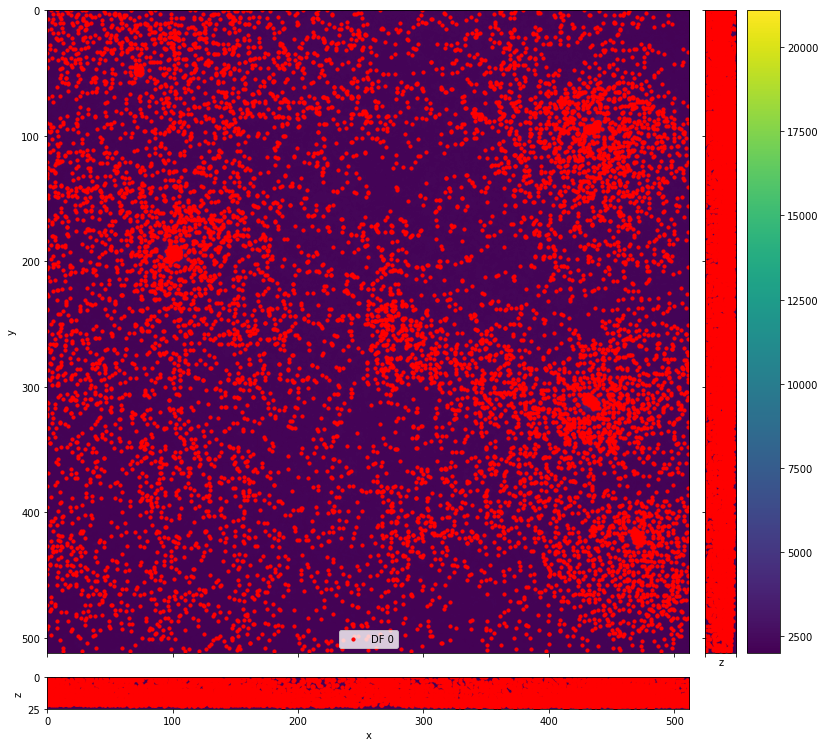

In [ ]:
from decode_fish.funcs.plotting import *
from decode_fish.funcs.emitter_io import *

fig, axes = plot_3d_projections(tiff[0], size=10)
scat_3d_projections(axes, [df])

In [ ]:
#export
def swap_psf_vol(psf, vol):
    state_dict = psf.state_dict()
    state_dict['psf_volume'][0] = torch.cuda.FloatTensor(torch.Tensor(vol).cuda())
    psf.load_state_dict(state_dict)
    return psf

def get_gaussian_psf(size_zyx, radii):
    psf = LinearInterpolatedPSF(size_zyx, device='cuda')
    gauss_vol = gaussian_sphere(size_zyx, radii, [size_zyx[0]//2,size_zyx[1]//2,size_zyx[2]//2])
    gauss_vol = gauss_vol/gauss_vol.max()
#     gauss_vol = np.log(gauss_vol+1e-6)
    psf = swap_psf_vol(psf, gauss_vol)
    return psf

def load_psf(cfg):

    if cfg.data_path.psf_path:
        if 'tif' in cfg.data_path.psf_path:
            psf_vol = load_tiff_image(cfg.data_path.psf_path)
            psf_vol = psf_vol/psf_vol.max()
            psf = LinearInterpolatedPSF(psf_vol.shape[-3:], cfg.PSF.device)
            psf = swap_psf_vol(psf, psf_vol)
            
        else:
            psf_state = torch.load(cfg.data_path.psf_path)
            psf = LinearInterpolatedPSF(psf_state['psf_volume'].shape[-3:], cfg.PSF.device)
            psf.load_state_dict(psf_state)

            if cfg.PSF.psf_extent_zyx:
                psf = crop_psf(psf,cfg.PSF.psf_extent_zyx)
                
    else:
        
        psf = get_gaussian_psf(cfg.PSF.psf_extent_zyx, cfg.PSF.gauss_radii)
        
    return psf

def load_psf_noise_micro(cfg):
    
    psf = load_psf(cfg)
    noise = hydra.utils.instantiate(cfg.noise)
    if 'max' in cfg.microscope.norm:
        micro = hydra.utils.instantiate(cfg.microscope, psf=psf, noise=noise).cuda()
    else:
        micro = hydra.utils.instantiate(cfg.microscope, psf=psf, noise=noise, sum_fac=psf.psf_volume.sum().item()).cuda()
    return psf, noise, micro

def load_post_proc(cfg):
    if cfg.other.pp == 'si':
        return hydra.utils.instantiate(cfg.post_proc_si)
    if cfg.other.pp == 'isi':
        return hydra.utils.instantiate(cfg.post_proc_isi)
    
def get_dataloader(cfg):

    if cfg.data_path.sm_fish_ch is not None:
        imgs_3d       = [load_tiff_image(f)[cfg.data_path.sm_fish_ch:cfg.data_path.sm_fish_ch+1] for f in sorted(glob.glob(cfg.data_path.image_path))]
    else:
        imgs_3d       = [load_tiff_image(f) for f in sorted(glob.glob(cfg.data_path.image_path))]
        
    roi_masks     = [get_roi_mask(img, tuple(cfg.roi_mask.pool_size), percentile= cfg.roi_mask.percentile) for img in imgs_3d]
    
    min_shape = tuple(np.stack([v.shape for v in imgs_3d]).min(0)[-3:])
    crop_zyx = (cfg.random_crop.crop_sz, cfg.random_crop.crop_sz,cfg.random_crop.crop_sz)
    if crop_zyx > min_shape:
        crop_zyx = tuple(np.stack([min_shape, crop_zyx]).min(0))
        print('Crop size larger than volume in at least one dimension. Crop size changed to', crop_zyx)
        
    gen_bg        = [hydra.utils.instantiate(cfg.bg_estimation.smoothing, z_size=crop_zyx[0])]
    
    if cfg.bg_estimation.fractal.scale:
        gen_bg.append(hydra.utils.instantiate(cfg.bg_estimation.fractal))
    
    rand_crop = RandomCrop3D(crop_zyx, roi_masks)

    probmap_generator = UniformValue(cfg.prob_generator.low, cfg.prob_generator.high)
    rate_tfms = [probmap_generator]
    
    dataset_tfms = [rand_crop]
    
    if cfg.foci is not None:
        if cfg.foci.n_foci_avg > 0:
            rate_tfms.append(hydra.utils.instantiate(cfg.foci))

    ds = DecodeDataset(volumes = imgs_3d,
                       dataset_tfms =  dataset_tfms, 
                       rate_tfms = rate_tfms, 
                       bg_tfms = gen_bg, 
                       device='cuda:0', 
                       num_iter=(cfg.training.num_iters) * cfg.training.bs) 

    decode_dl = DataLoader(ds, batch_size=cfg.training.bs, num_workers=0)
    
    return imgs_3d, decode_dl
    
def load_all(cfg):
    
    path = Path(cfg.output.save_dir)
    model = hydra.utils.instantiate(cfg.model)
    model = load_model_state(model, path/'model.pkl')
    post_proc = hydra.utils.instantiate(cfg.post_proc_isi, samp_threshold=0.5)
    _, noise, micro = load_psf_noise_micro(cfg)
    micro.load_state_dict(torch.load(path/'microscope.pkl'))
    img_3d, decode_dl = get_dataloader(cfg)
    
    return model, post_proc, micro, img_3d, decode_dl

In [ ]:
cfg = OmegaConf.load('../config/experiment/MERFISH_starfish_c1.yaml')
# cfg = OmegaConf.load(default_conf)
# psf = load_psf(cfg)
# psf.load_state_dict(torch.load(Path(cfg.output.save_dir)/'psf.pkl'))

In [ ]:
imgs_3d, decode_dl = get_dataloader(cfg)

Crop size larger than volume in at least one dimension. Crop size changed to (1, 48, 48)


/groups/turaga/home/speisera/anaconda3/envs/decode2_dev/lib/python3.7/site-packages/torch/cuda/__init__.py:81: UserWarning: 
    Found GPU2 NVS 510 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability that we support is 3.5.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


1 volumes


In [ ]:
imgs_3d[0].shape

torch.Size([1, 1, 2048, 2048])

In [ ]:
torch.clamp_min(psf.psf_volume[0],0).sum()

In [ ]:
psf.psf_volume[0].max()

tensor(1., grad_fn=<MaxBackward1>)

array([<AxesSubplot:xlabel='x', ylabel='y'>,
       <AxesSubplot:xlabel='x', ylabel='z'>,
       <AxesSubplot:xlabel='y', ylabel='z'>], dtype=object)

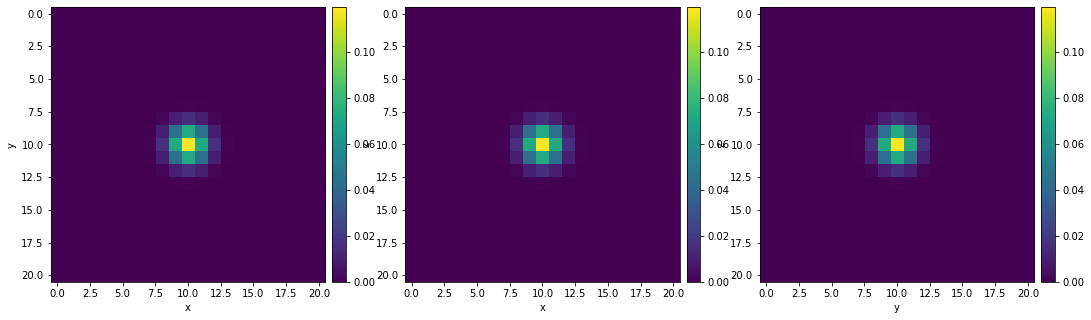

In [ ]:
from decode_fish.funcs.plotting import *
plot_3d_projections(psf.psf_volume[0])

In [ ]:
import re

def inferReader(filename, verbose = False):
    """
    Given a file name this will try to return the appropriate
    reader based on the file extension.
    """
    ext = os.path.splitext(filename)[1]
    if (ext == ".dax"):
        return DaxReader(filename, verbose = verbose)
    elif (ext == ".fits"):
        return FITSReader(filename, verbose = verbose)
    elif (ext == ".spe"):
        return SpeReader(filename, verbose = verbose)
    elif (ext == ".tif") or (ext == ".tiff"):
        return TifReader(filename, verbose = verbose)
    else:
        print(ext, "is not a recognized file type")
        raise IOError("only .dax, .spe and .tif are supported (case sensitive..)")


class Reader(object):
    """
    The superclass containing those functions that 
    are common to reading a STORM movie file.
    Subclasses should implement:
     1. __init__(self, filename, verbose = False)
        This function should open the file and extract the
        various key bits of meta-data such as the size in XY
        and the length of the movie.
     2. loadAFrame(self, frame_number)
        Load the requested frame and return it as np array.
    """
    def __init__(self, filename, verbose = False):
        super(Reader, self).__init__()
        self.filename = filename
        self.fileptr = None
        self.verbose = verbose

    def __del__(self):
        self.close()

    def __enter__(self):
        return self

    def __exit__(self, etype, value, traceback):
        self.close()

    def averageFrames(self, start = None, end = None):
        """
        Average multiple frames in a movie.
        """
        length = 0
        average = np.zeros((self.image_height, self.image_width), np.float)
        for [i, frame] in self.frameIterator(start, end):
            if self.verbose and ((i%10)==0):
                print(" processing frame:", i, " of", self.number_frames)
            length += 1
            average += frame

        if (length > 0):
            average = average/float(length)
            
        return average

    def close(self):
        if self.fileptr is not None:
            self.fileptr.close()
            self.fileptr = None
        
    def filmFilename(self):
        """
        Returns the film name.
        """
        return self.filename

    def filmSize(self):
        """
        Returns the film size.
        """
        return [self.image_width, self.image_height, self.number_frames]

    def filmLocation(self):
        """
        Returns the picture x,y location, if available.
        """
        if hasattr(self, "stage_x"):
            return [self.stage_x, self.stage_y]
        else:
            return [0.0, 0.0]

    def filmScale(self):
        """
        Returns the scale used to display the film when
        the picture was taken.
        """
        if hasattr(self, "scalemin") and hasattr(self, "scalemax"):
            return [self.scalemin, self.scalemax]
        else:
            return [100, 2000]

    def frameIterator(self, start = None, end = None):
        """
        Iterator for going through the frames of a movie.
        """
        if start is None:
            start = 0
        if end is None:
            end = self.number_frames 

        for i in range(start, end):
            yield [i, self.loadAFrame(i)]
        
    def hashID(self):
        """
        A (hopefully) unique string that identifies this movie.
        """
        return hashlib.md5(self.loadAFrame(0).tostring()).hexdigest()

    def loadAFrame(self, frame_number):
        assert frame_number >= 0, "Frame_number must be greater than or equal to 0, it is " + str(frame_number)
        assert frame_number < self.number_frames, "Frame number must be less than " + str(self.number_frames)
        
    def lockTarget(self):
        """
        Returns the film focus lock target.
        """
        if hasattr(self, "lock_target"):
            return self.lock_target
        else:
            return 0.0

class DaxReader(Reader):
    """
    Dax reader class. This is a Zhuang lab custom format.
    """
    def __init__(self, filename, verbose = False):
        super(DaxReader, self).__init__(filename, verbose = verbose)
        
        # save the filenames
        dirname = os.path.dirname(filename)
        if (len(dirname) > 0):
            dirname = dirname + "/"
        self.inf_filename = dirname + os.path.splitext(os.path.basename(filename))[0] + ".inf"

        # defaults
        self.image_height = None
        self.image_width = None

        # extract the movie information from the associated inf file
        size_re = re.compile(r'frame dimensions = ([\d]+) x ([\d]+)')
        length_re = re.compile(r'number of frames = ([\d]+)')
        endian_re = re.compile(r' (big|little) endian')
        stagex_re = re.compile(r'Stage X = ([\d\.\-]+)')
        stagey_re = re.compile(r'Stage Y = ([\d\.\-]+)')
        lock_target_re = re.compile(r'Lock Target = ([\d\.\-]+)')
        scalemax_re = re.compile(r'scalemax = ([\d\.\-]+)')
        scalemin_re = re.compile(r'scalemin = ([\d\.\-]+)')

        inf_file = open(self.inf_filename, "r")
        while 1:
            line = inf_file.readline()
            if not line: break
            m = size_re.match(line)
            if m:
                self.image_height = int(m.group(2))
                self.image_width = int(m.group(1))
            m = length_re.match(line)
            if m:
                self.number_frames = int(m.group(1))
            m = endian_re.search(line)
            if m:
                if m.group(1) == "big":
                    self.bigendian = 1
                else:
                    self.bigendian = 0
            m = stagex_re.match(line)
            if m:
                self.stage_x = float(m.group(1))
            m = stagey_re.match(line)
            if m:
                self.stage_y = float(m.group(1))
            m = lock_target_re.match(line)
            if m:
                self.lock_target = float(m.group(1))
            m = scalemax_re.match(line)
            if m:
                self.scalemax = int(m.group(1))
            m = scalemin_re.match(line)
            if m:
                self.scalemin = int(m.group(1))

        inf_file.close()

        # set defaults, probably correct, but warn the user 
        # that they couldn't be determined from the inf file.
        if not self.image_height:
            print("Could not determine image size, assuming 256x256.")
            self.image_height = 256
            self.image_width = 256

        # open the dax file
        if os.path.exists(filename):
            self.fileptr = open(filename, "rb")
        else:
            if self.verbose:
                print("dax data not found", filename)

    def loadAFrame(self, frame_number):
        """
        Load a frame & return it as a np array.
        """
        super(DaxReader, self).loadAFrame(frame_number)

        self.fileptr.seek(frame_number * self.image_height * self.image_width * 2)
        image_data = np.fromfile(self.fileptr, dtype='uint16', count = self.image_height * self.image_width)
        image_data = np.reshape(image_data, [self.image_height, self.image_width])
        if self.bigendian:
            image_data.byteswap(True)
        return image_data

In [ ]:
bla = DaxReader('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/datasets/CodFish/MERFISH/zhuang_3/image_data/movie_subset_0000.dax')

In [ ]:
bla = DaxReader('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/datasets/CodFish/MERFISH/zhuang_1/MERFISH_Examples/example_data/STORM_05_01_c1.dax')

In [ ]:
tra = [bla.loadAFrame(i) for i in range(1)]

In [ ]:
tra = np.stack(tra)

In [ ]:
tra.shape

(1, 256, 256)

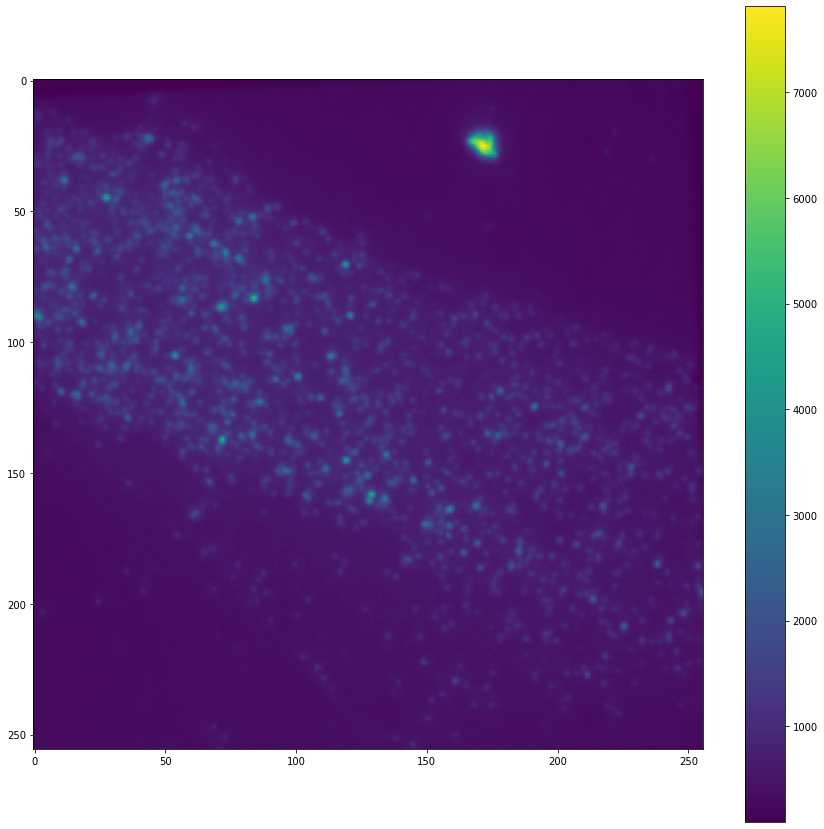

In [ ]:
plt.figure(figsize=(15,15))
plt.imshow(tra.mean(0))
plt.colorbar()

In [ ]:
!nbdev_build_lib

Converted 00_models.ipynb.
Converted 01_psf.ipynb.
Converted 02_microscope.ipynb.
Converted 03_noise.ipynb.
Converted 04_pointsource.ipynb.
Converted 05_gmm_loss.ipynb.
Converted 06_plotting.ipynb.
Converted 07_file_io.ipynb.
Converted 08_dataset.ipynb.
Converted 09_output_trafo.ipynb.
Converted 10_evaluation.ipynb.
Converted 11_emitter_io.ipynb.
Converted 12_utils.ipynb.
Converted 13_train.ipynb.
Converted 15_fit_psf.ipynb.
Converted 16_visualization.ipynb.
Converted 17_eval_routines.ipynb.
Converted 18_predict_funcs.ipynb.
Converted index.ipynb.
